In [1]:
import sys
import os

In [2]:
sys.path.append('..')

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score



pd.set_option('display.width', 120)

%matplotlib inline

plt.rcParams["figure.figsize"] = (24,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True 

plt.rcParams['font.family']='AppleGothic'

In [4]:
from utils.prepare_data import *
from utils.model_helper import *

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from custum_dataset import digi_data_load, testcase_add_data_load, testcase_shuffle_data_load
from attn_bi_lstm import ABLSTM

In [6]:
df = pd.read_csv('../../nlu-model-analysis/binary_dataset.csv',sep='\t',index_col='Unnamed: 0')
df = df.sample(len(df),random_state=10)
df['class'] = df['class'].apply(lambda x: x if x== 1 else 0 )
df

,sent,class,binary_class
24879,디스플레이,0,0
33870,로우,0,0
104066,코렐,0,0
8224,쿠폰 안되나요,0,1
6641,쿠폰요,0,1
101506,헤어장식,0,0
89576,현금영수증 발행이 필요해요,0,1
93839,bh6083,0,0
6959,담에 하겠습니다,0,1
33793,알려주세요,0,0


In [7]:
train_df = df.iloc[:int(len(df)*0.8)]
test_df = df.iloc[int(len(df)*0.8):]

In [8]:
TRAIN_DOC, TRAIN_LABEL, TEST_DOC, TEST_LABEL = train_df['sent'], train_df['class'], test_df['sent'], test_df['class']

In [9]:
train_intent = TRAIN_LABEL
test_intent = TEST_LABEL

In [10]:
%%time
train_doc = TRAIN_DOC.tolist()
test_doc = TEST_DOC.tolist()

#train_doc = pd.Series(list(map(lambda x: ' '.join(twitter.morphs(x)), train_doc)))
#test_doc = pd.Series(list(map(lambda x: ' '.join(twitter.morphs(x)), test_doc)))
train_doc = pd.Series(list(map(lambda x: ' '.join(list(x.replace(' ','ⓢ'))), train_doc)))
test_doc = pd.Series(list(map(lambda x: ' '.join(list(x.replace(' ','ⓢ'))), test_doc)))

CPU times: user 221 ms, sys: 10.5 ms, total: 232 ms
Wall time: 231 ms


In [11]:
y_train = pd.Series(train_intent.tolist())
y_test = pd.Series(test_intent.tolist())

In [12]:
x_train, x_test, tokenizer = \
        data_preprocessing_v2(train_doc, test_doc, max_len=64)
vocab_size = tokenizer.num_words

In [13]:
test_size = len(x_test)

config = {
    "max_len": 64,
    "hidden_size": 64,
    "vocab_size": vocab_size,
    "embedding_size": 128,
    "n_class": 2,
    "learning_rate": 1e-3,
    "batch_size": 128,
    "train_epoch": 20
}
modelname = 'binary_classifier'

In [14]:
sess = tf.Session()

classifier = ABLSTM(sess, config)
classifier.build_graph(modelname)

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

resume = True
if resume:
    saver.restore(sess, "./Saver/{}/{}.ckpt".format(modelname, modelname))


preds = []
probas = []
reals = []
attns = []
for x_batch, y_batch in fill_feed_dict(x_test, y_test,len(test_doc), isshuffle=False):
    pred, proba = get_prediction(classifier, sess, (x_batch, y_batch))
    attn = get_attn_weight(classifier, sess, (x_batch, y_batch),0.1)
    preds += pred.tolist()
    probas += proba.tolist()
    attns += attn.tolist()
    reals += y_batch.tolist()

building graph
graph built successfully!
INFO:tensorflow:Restoring parameters from ./Saver/binary_classifier/binary_classifier.ckpt


In [15]:
test_df = pd.DataFrame({'sent':test_doc,'attn':attns, 'pred':preds, 'real':reals,'proba':probas})
test_df

,sent,attn,pred,real,proba
0,마 트 ⓢ 카 테 고 리 ⓢ 일 반 ⓢ 쿠 폰 은 ⓢ 다 운 받 을 ⓢ 수 ⓢ 없 ...,"[0.017022913321852684, 0.019267244264483452, 0...",1,0,"[0.044728267937898636, 0.9552717208862305]"
1,산 토 리 니 ⓢ 타 프,"[0.020931914448738098, 0.02105770818889141, 0....",0,0,"[0.9702392220497131, 0.029760753735899925]"
2,시 트 지,"[0.0335674025118351, 0.03335944935679436, 0.03...",0,0,"[0.9519839882850647, 0.0480160266160965]"
3,새 채 팅,"[0.062198005616664886, 0.04655924439430237, 0....",0,0,"[0.8508937954902649, 0.1491062194108963]"
4,o k 케 시 백 ⓢ 등 록,"[0.038695674389600754, 0.03879527375102043, 0....",1,0,"[0.3234825134277344, 0.6765174865722656]"
5,공 기 청 정 기 ⓢ 렌 탈,"[0.02144421637058258, 0.022644763812422752, 0....",0,0,"[0.9851985573768616, 0.01480146124958992]"
6,선 ⓢ 없 는 ⓢ 청 소 기,"[0.01589641533792019, 0.013863308355212212, 0....",0,0,"[0.9874556064605713, 0.012544376775622368]"
7,방 등,"[0.021275939419865608, 0.025934074074029922, 0...",0,0,"[0.989721953868866, 0.010278076864778996]"
8,크 로 스 ⓢ 케 스 트,"[0.013630877248942852, 0.014861839823424816, 0...",0,0,"[0.9904630780220032, 0.009536942467093468]"
9,바 네 스 데 코 ⓢ 전 자 랜 지 ⓢ 다 이 ⓢ 주 문 했 는 데 ⓢ 배 송 이 ...,"[0.01430448517203331, 0.009779291227459908, 0....",1,0,"[0.008470340631902218, 0.9915297031402588]"


In [16]:
f1_score(test_df['real'],test_df['pred'],average='weighted')

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.7107190910449993

In [17]:
test_df[test_df['real'] == test_df['pred']]

,sent,attn,pred,real,proba
1,산 토 리 니 ⓢ 타 프,"[0.020931914448738098, 0.02105770818889141, 0....",0,0,"[0.9702392220497131, 0.029760753735899925]"
2,시 트 지,"[0.0335674025118351, 0.03335944935679436, 0.03...",0,0,"[0.9519839882850647, 0.0480160266160965]"
3,새 채 팅,"[0.062198005616664886, 0.04655924439430237, 0....",0,0,"[0.8508937954902649, 0.1491062194108963]"
5,공 기 청 정 기 ⓢ 렌 탈,"[0.02144421637058258, 0.022644763812422752, 0....",0,0,"[0.9851985573768616, 0.01480146124958992]"
6,선 ⓢ 없 는 ⓢ 청 소 기,"[0.01589641533792019, 0.013863308355212212, 0....",0,0,"[0.9874556064605713, 0.012544376775622368]"
7,방 등,"[0.021275939419865608, 0.025934074074029922, 0...",0,0,"[0.989721953868866, 0.010278076864778996]"
8,크 로 스 ⓢ 케 스 트,"[0.013630877248942852, 0.014861839823424816, 0...",0,0,"[0.9904630780220032, 0.009536942467093468]"
11,오 늘 은 ⓢ 안 살 꺼 야,"[0.031243357807397842, 0.04246201366186142, 0....",0,0,"[0.8115977644920349, 0.18840228021144867]"
12,콧 털 깍 기 도 있 냐 ?,"[0.03806786984205246, 0.03418521583080292, 0.0...",0,0,"[0.8438977599143982, 0.15610218048095703]"
13,뭐 임,"[0.06733221560716629, 0.05883614718914032, 0.0...",0,0,"[0.6038873195648193, 0.3961126506328583]"


In [18]:
def add_pad(text):
    max_len = 64
    text = text.replace(' ','')
    text = text + 'ⓟ'*(64-len(text))
    return text[:64]

In [19]:
test_df['sent'] = test_df['sent'].apply(add_pad)

In [20]:
def summary_pattern(text, attn):
    # pad 삭제
    text = text.replace('ⓟ','')
    attn = attn[:len(text)]
    sum_attns = []
    sum_attn = 0
    for i, char in enumerate(text):
        if char == 'ⓢ':
            sum_attns.append(sum_attn)
            sum_attn = 0
        sum_attn += attn[i]
    sum_attns.append(sum_attn)
    
    df = pd.DataFrame({'word':text.split('ⓢ'),'sum_attn':sum_attns})
    
    df['selected'] = 0
    df = df.sort_values('sum_attn',ascending=False)

    words = []
    word_attn = 0
    for i, row in df.iterrows():
        word_attn += row['sum_attn']
        df.loc[df.word == row['word'],'selected'] = 1
        
        if word_attn > 0.95:
            return df.sort_index()
    
    return None
    # space단위 attn 합산
    # attn 합산 ordering해서 90되면 stop
    # text 리턴

0 1 0.9817901253700256


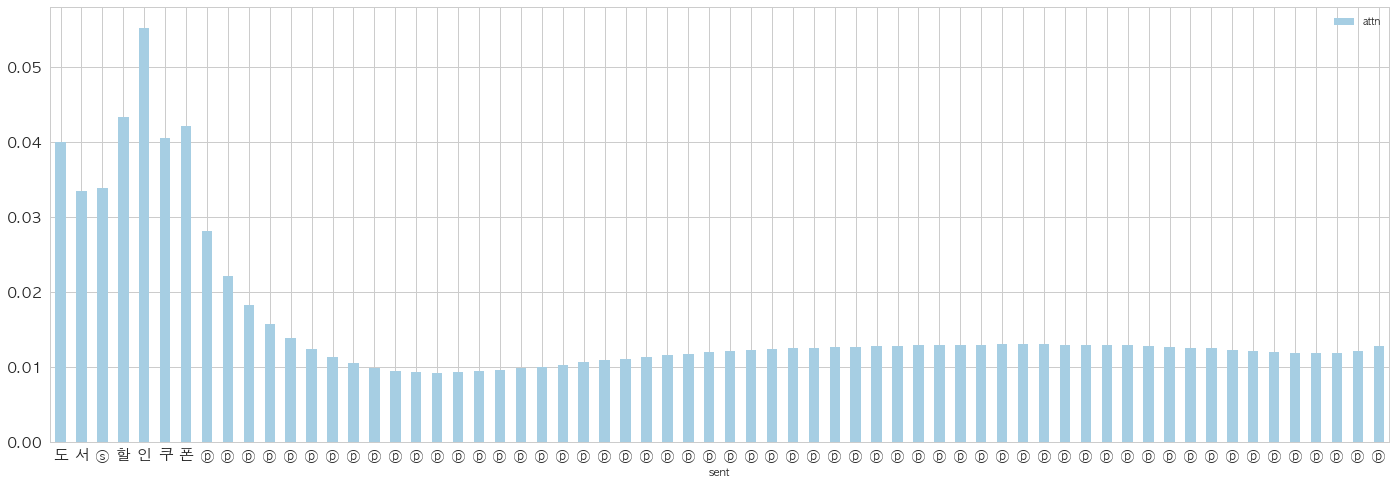

In [21]:
index = 10
row = pd.DataFrame({'sent':list(test_df['sent'][index]), 'attn':test_df['attn'][index]}) 
ax = row.plot.bar(x='sent',y='attn',rot=0,colormap='Paired',fontsize= 15)
print(test_df['real'][index], test_df['pred'][index], max(test_df['proba'][index]) )

In [22]:
summary_pattern(test_df['sent'][index],test_df['attn'][index])

In [23]:
def predict(sess, model, text):
    text_idx = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_idx, maxlen=config['max_len'],padding='post',truncating='post')
    text_padded = np.concatenate([text_padded, text_padded])
    pred, proba, attn = sess.run([model.prediction, model.proba, model.alpha], 
                           feed_dict={model.x:text_padded,
                                      model.keep_prob:1.0})
    return pred[0], max(proba[0]), attn[0]

In [24]:
def run_test():
    print('TEST START!')
    while True:
        text = input("RAW Text를 입력하세요!\t")
        text = ' '.join(list(text.replace(' ','ⓢ')))
        speech_act, prob, attns = predict(sess, classifier, text)
        text_pad = add_pad(text)
        row = pd.DataFrame({'sent':list(text_pad), 'attn':attns}) 
        ax = row.plot.bar(x='sent',y='attn',rot=0,colormap='Paired',fontsize= 15)
        print('\n',text,' -> ', speech_act,'({})'.format(prob))
        print()
        print(summary_pattern(text_pad,attns))
        break

TEST START!
RAW Text를 입력하세요!	hey what your name

 h e y ⓢ w h a t ⓢ y o u r ⓢ n a m e  ->  0 (0.7473581433296204)

None


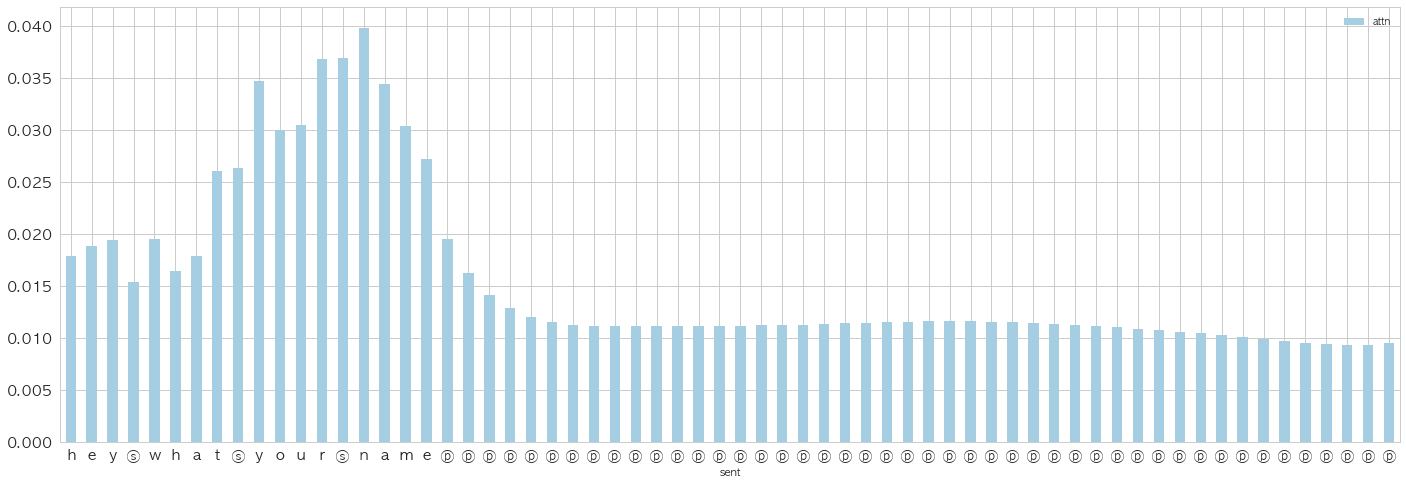

In [26]:
run_test()